Adapted from https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb

In [5]:
%mkdir BDLib
%cd BDLib
!test ! -f "BDLib-2.zip" && wget "http://research.playcompass.com/files/BDLib-2.zip"

mkdir: cannot create directory ‘BDLib’: File exists
/home/xiaofan/Github/ESC50-torch/BDLib


In [2]:
!unzip -qq BDLib-2.zip

In [6]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

## Now training and testing on BDLib

In [7]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [8]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [19]:
all_labels = ['airplane', 
              'alarms',
              'applause',
              'birds',
              'dogs',
              'motorcycles',
              'rain',
              'rivers',
              'seawaves',
              'thunders']

class BDLibData(Dataset):
  def __init__(self, base, test_partition=0.3, mode='train'):
    self.data = []
    self.labels = []
    self.num_classes = 10
    
    # Read all samples
    for id in [1, 2, 3]:
      dir_path = os.path.join(base, 'fold-{}'.format(id))
      all_files = os.listdir(dir_path)
      for ind in range(len(all_files)):
        file_path = os.path.join(dir_path, all_files[ind])
        self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
        label = all_files[ind].split('.')[0].rstrip('0123456789')
        # print(label)
        self.labels.append(all_labels.index(label))

    self.data = np.array(self.data)
    self.labels = np.array(self.labels)

    # Partition training and testing samples randomly per class, and save the testing indexes
    test_samples_idx = []
    for c in tqdm(range(self.num_classes)):
      class_mask = (self.labels == c)
      class_test_num = int(class_mask.sum() * test_partition)
      class_test_idx = np.random.choice(np.arange(self.labels.shape[0])[class_mask],
                                           size=class_test_num,
                                           replace=False).astype('int')
      test_samples_idx.extend(class_test_idx.tolist())
    test_samples_idx.sort()
    test_samples_idx =  np.array(test_samples_idx)

    if mode == 'train':
      self.data = np.delete(self.data, test_samples_idx, axis=0)
      self.labels = np.delete(self.labels, test_samples_idx, axis=0)
      np.savetxt(os.path.join(base, 'test_samples_idx.txt'), test_samples_idx)
    else:  # test
      test_samples_idx = np.loadtxt(os.path.join(base, 'test_samples_idx.txt')).astype('int')
      self.data = self.data[test_samples_idx]
      self.labels = self.labels[test_samples_idx]
    
    print(mode, self.data.shape, self.labels.shape)
    print(self.data.dtype, self.labels.dtype)

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]
  
train_data = BDLibData('./', mode='train')
valid_data = BDLibData('./', mode='test')

# A simpler version of loader
"""class BDLibData(Dataset):
  def __init__(self, base, fold_ids):
    self.data = []
    self.labels = []
    self.num_classes = 10
    
    # Read all samples
    for id in fold_ids:
      dir_path = os.path.join(base, 'fold-{}'.format(id))
      all_files = os.listdir(dir_path)
      for ind in range(len(all_files)):
        file_path = os.path.join(dir_path, all_files[ind])
        self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
        label = all_files[ind].split('.')[0].rstrip('0123456789')
        # print(label)
        self.labels.append(all_labels.index(label))

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]
  
train_data = BDLibData('./', [1, 2])
valid_data = BDLibData('./', [3])"""

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))

print(train_data.data[0].shape)

100%|██████████| 10/10 [00:00<00:00, 11535.49it/s]


train (130, 1, 128, 431) (130,)
uint8 int64


100%|██████████| 10/10 [00:00<00:00, 11507.01it/s]

test (50, 1, 128, 431) (50,)
uint8 int64
train data length 130
valid data length 50
(1, 128, 431)


In [20]:
from torchvision.models import resnet18
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet18(pretrained=True)
resnet_model.fc = nn.Linear(512,10)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [22]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  4%|▍         | 2/50 [00:00<00:08,  5.60it/s]

Epoch - 1 Train-Loss : 1.671095026863946
Epoch - 1 Valid-Loss : 1.7340365648269653 Valid-Accuracy : 0.54
Epoch - 2 Train-Loss : 0.6306387715869479
Epoch - 2 Valid-Loss : 0.9893710911273956 Valid-Accuracy : 0.68


  8%|▊         | 4/50 [00:00<00:07,  6.38it/s]

Epoch - 3 Train-Loss : 0.54905823038684
Epoch - 3 Valid-Loss : 0.6178491092287004 Valid-Accuracy : 0.78
Epoch - 4 Train-Loss : 0.29875512089994216
Epoch - 4 Valid-Loss : 0.8159659504890442 Valid-Accuracy : 0.74


 12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

Epoch - 5 Train-Loss : 0.3422326064772076
Epoch - 5 Valid-Loss : 0.38474111957475543 Valid-Accuracy : 0.8
Epoch - 6 Train-Loss : 0.22060874166587988
Epoch - 6 Valid-Loss : 0.8951922804117203 Valid-Accuracy : 0.84


 16%|█▌        | 8/50 [00:01<00:06,  6.76it/s]

Epoch - 7 Train-Loss : 0.1500617480940289
Epoch - 7 Valid-Loss : 0.5226838027592748 Valid-Accuracy : 0.82
Epoch - 8 Train-Loss : 0.1148497634049919
Epoch - 8 Valid-Loss : 0.45024574967101216 Valid-Accuracy : 0.84


 20%|██        | 10/50 [00:01<00:05,  6.82it/s]

Epoch - 9 Train-Loss : 0.1892976500093937
Epoch - 9 Valid-Loss : 0.5572441052645445 Valid-Accuracy : 0.82
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.5140764906795489
Epoch - 10 Valid-Loss : 0.5797675810754299 Valid-Accuracy : 0.82


 24%|██▍       | 12/50 [00:01<00:05,  6.84it/s]

Epoch - 11 Train-Loss : 0.129952740131153
Epoch - 11 Valid-Loss : 1.0046100169420242 Valid-Accuracy : 0.84
Epoch - 12 Train-Loss : 0.0825745038067301
Epoch - 12 Valid-Loss : 0.633613295853138 Valid-Accuracy : 0.84


 28%|██▊       | 14/50 [00:02<00:05,  6.89it/s]

Epoch - 13 Train-Loss : 0.080110608237899
Epoch - 13 Valid-Loss : 0.5087129981257021 Valid-Accuracy : 0.86
Epoch - 14 Train-Loss : 0.07654337305575609
Epoch - 14 Valid-Loss : 0.6617557406425476 Valid-Accuracy : 0.86


 32%|███▏      | 16/50 [00:02<00:04,  6.90it/s]

Epoch - 15 Train-Loss : 0.12624779550565612
Epoch - 15 Valid-Loss : 0.5226907283067703 Valid-Accuracy : 0.84
Epoch - 16 Train-Loss : 0.11987736443471578
Epoch - 16 Valid-Loss : 0.47192461986560374 Valid-Accuracy : 0.86


 36%|███▌      | 18/50 [00:02<00:04,  6.90it/s]

Epoch - 17 Train-Loss : 0.031317835259768695
Epoch - 17 Valid-Loss : 0.5712588131427765 Valid-Accuracy : 0.84
Epoch - 18 Train-Loss : 0.050309251424753
Epoch - 18 Valid-Loss : 0.5939064249396324 Valid-Accuracy : 0.82


 40%|████      | 20/50 [00:02<00:04,  6.89it/s]

Epoch - 19 Train-Loss : 0.08421953591621584
Epoch - 19 Valid-Loss : 0.43582873279228806 Valid-Accuracy : 0.86
Changed learning rate to 2e-06
Epoch - 20 Train-Loss : 0.08108767753260003
Epoch - 20 Valid-Loss : 0.5014518648386002 Valid-Accuracy : 0.84


 44%|████▍     | 22/50 [00:03<00:04,  6.90it/s]

Epoch - 21 Train-Loss : 0.38437931969140965
Epoch - 21 Valid-Loss : 0.5324381291866302 Valid-Accuracy : 0.84
Epoch - 22 Train-Loss : 0.05784340746079882
Epoch - 22 Valid-Loss : 0.41543076816014946 Valid-Accuracy : 0.86


 48%|████▊     | 24/50 [00:03<00:03,  6.90it/s]

Epoch - 23 Train-Loss : 0.12809983387382495
Epoch - 23 Valid-Loss : 0.44237180799245834 Valid-Accuracy : 0.84
Epoch - 24 Train-Loss : 0.10957514194564687
Epoch - 24 Valid-Loss : 0.5107517205178738 Valid-Accuracy : 0.84


 52%|█████▏    | 26/50 [00:03<00:03,  6.92it/s]

Epoch - 25 Train-Loss : 0.07360681239515543
Epoch - 25 Valid-Loss : 0.49172508902847767 Valid-Accuracy : 0.84
Epoch - 26 Train-Loss : 0.05018180991626448
Epoch - 26 Valid-Loss : 0.8122719973325729 Valid-Accuracy : 0.86


 56%|█████▌    | 28/50 [00:04<00:03,  6.92it/s]

Epoch - 27 Train-Loss : 0.06878918699092335
Epoch - 27 Valid-Loss : 0.529179759323597 Valid-Accuracy : 0.86
Epoch - 28 Train-Loss : 0.09840268269181252
Epoch - 28 Valid-Loss : 0.41606437554582953 Valid-Accuracy : 0.86


 60%|██████    | 30/50 [00:04<00:02,  6.92it/s]

Epoch - 29 Train-Loss : 0.04228348662662837
Epoch - 29 Valid-Loss : 0.6395356692373753 Valid-Accuracy : 0.86
Changed learning rate to 2.0000000000000002e-07
Epoch - 30 Train-Loss : 0.06733305685015188
Epoch - 30 Valid-Loss : 0.46206829976290464 Valid-Accuracy : 0.86


 64%|██████▍   | 32/50 [00:04<00:02,  6.93it/s]

Epoch - 31 Train-Loss : 0.08165888188199864
Epoch - 31 Valid-Loss : 0.4319535044487566 Valid-Accuracy : 0.86
Epoch - 32 Train-Loss : 0.3477862099599507
Epoch - 32 Valid-Loss : 0.467982460744679 Valid-Accuracy : 0.88


 68%|██████▊   | 34/50 [00:05<00:02,  6.92it/s]

Epoch - 33 Train-Loss : 0.07426202131642236
Epoch - 33 Valid-Loss : 0.4509620334720239 Valid-Accuracy : 0.86
Epoch - 34 Train-Loss : 0.10067930082894033
Epoch - 34 Valid-Loss : 0.4425183308776468 Valid-Accuracy : 0.86


 72%|███████▏  | 36/50 [00:05<00:02,  6.91it/s]

Epoch - 35 Train-Loss : 0.10071592229521936
Epoch - 35 Valid-Loss : 0.471315745569882 Valid-Accuracy : 0.84
Epoch - 36 Train-Loss : 0.08497460450356205
Epoch - 36 Valid-Loss : 0.49805497005581856 Valid-Accuracy : 0.86


 76%|███████▌  | 38/50 [00:05<00:01,  6.88it/s]

Epoch - 37 Train-Loss : 0.0876417113468051
Epoch - 37 Valid-Loss : 0.4797978466376662 Valid-Accuracy : 0.82
Epoch - 38 Train-Loss : 0.11086018797424105
Epoch - 38 Valid-Loss : 0.48824745207093656 Valid-Accuracy : 0.82


 80%|████████  | 40/50 [00:05<00:01,  6.89it/s]

Epoch - 39 Train-Loss : 0.049468621559855014
Epoch - 39 Valid-Loss : 0.5024698908309801 Valid-Accuracy : 0.84
Changed learning rate to 2e-08
Epoch - 40 Train-Loss : 0.050632055227955185
Epoch - 40 Valid-Loss : 0.45580168085871264 Valid-Accuracy : 0.84


 84%|████████▍ | 42/50 [00:06<00:01,  6.90it/s]

Epoch - 41 Train-Loss : 0.06823521836971243
Epoch - 41 Valid-Loss : 0.4875159524381161 Valid-Accuracy : 0.86
Epoch - 42 Train-Loss : 0.06854949167205228
Epoch - 42 Valid-Loss : 0.4765941465739161 Valid-Accuracy : 0.8


 88%|████████▊ | 44/50 [00:06<00:00,  6.90it/s]

Epoch - 43 Train-Loss : 0.20734904013160202
Epoch - 43 Valid-Loss : 0.45092362724244595 Valid-Accuracy : 0.84
Epoch - 44 Train-Loss : 0.1211243659361369
Epoch - 44 Valid-Loss : 0.44007343030534685 Valid-Accuracy : 0.82


 92%|█████████▏| 46/50 [00:06<00:00,  6.90it/s]

Epoch - 45 Train-Loss : 0.04463871247652504
Epoch - 45 Valid-Loss : 0.4357275669462979 Valid-Accuracy : 0.84
Epoch - 46 Train-Loss : 0.34231058621986044
Epoch - 46 Valid-Loss : 0.8101527318358421 Valid-Accuracy : 0.86


 96%|█████████▌| 48/50 [00:07<00:00,  6.91it/s]

Epoch - 47 Train-Loss : 0.0802289644877116
Epoch - 47 Valid-Loss : 0.710137628018856 Valid-Accuracy : 0.86
Epoch - 48 Train-Loss : 0.10234777489677072
Epoch - 48 Valid-Loss : 0.48022023029625416 Valid-Accuracy : 0.84


100%|██████████| 50/50 [00:07<00:00,  6.82it/s]

Epoch - 49 Train-Loss : 0.11471714726131824
Epoch - 49 Valid-Loss : 0.4513228174764663 Valid-Accuracy : 0.86
Changed learning rate to 2e-09
Epoch - 50 Train-Loss : 0.08097063201583093
Epoch - 50 Valid-Loss : 0.5367873907089233 Valid-Accuracy : 0.86


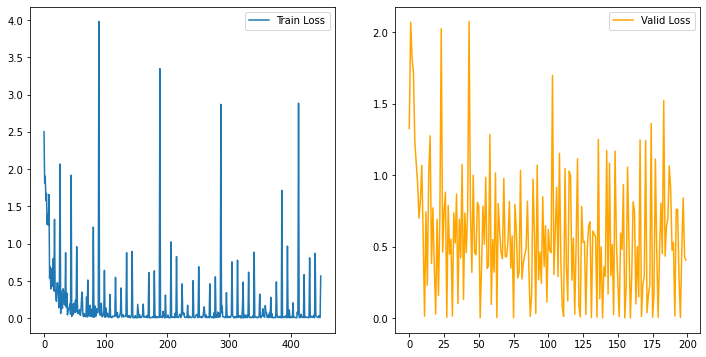

In [23]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
